# ML Model Diagnosis

In this lab you will implement the training set size experiment described in class, and also explore transfer learning using a pre-trained convolutional neural network (CNN) for image classification.

We will use the [Intel Image Classification dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification).  Download it from Kaggle or from [OneDrive](https://cpslo-my.sharepoint.com/:u:/g/personal/jventu09_calpoly_edu/EW40XA_u31RNil1YzmBX-GUBSsqjb508K-iBA2ka5Uri_A?e=webnMY).

In [1]:
import glob
import imageio
import skimage
from matplotlib import pyplot as plt
import numpy as np
import tensorflow
import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


Here is some code to load the dataset.

In [2]:
label_names = ['buildings','forest','glacier','mountain','sea','street']

In [3]:
def load_split(split):
    images = []
    labels = []
    for label in label_names:
        image_paths = sorted(glob.glob(f'archive/seg_{split}/seg_{split}/{label}/*.jpg'))
        for path in image_paths:
            image = imageio.imread(path)
            if len(image.shape)<3:
                continue
            if image.shape[0]!=150 or image.shape[1]!=150 or image.shape[2]!=3:
                continue
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_split('train')
test_images, test_labels = load_split('test')

/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_80382/1112897.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)


Text(0.5, 1.0, 'buildings')

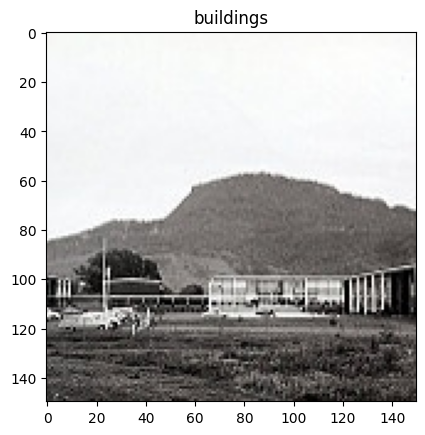

In [4]:
plt.imshow(train_images[0])
plt.title(train_labels[0])

This time we will randomly shuffle the training set, to support our later experiments.

In [5]:
inds = list(range(len(train_images)))
np.random.shuffle(inds)
train_images = train_images[inds]
train_labels = train_labels[inds]

Now we have arrays `train_images` and `train_labels` containing the images and labels for the training set, and the same for the test set.

Here we create a [MobileNetV2](https://arxiv.org/abs/1801.04381) model and download its pre-trained weights.  MobileNetV2 is a lightweight but high-performing CNN.  You can read about other Keras pre-trained models [here](https://keras.io/api/applications/).

The ```include_top=False``` argument tells Keras that we don't want the part of the network that is for 1000-class classification using the ImageNet labels.  Instead we take only the part of the network that computes a descriptor for the image (sometimes called an "embedding" or "latent vector" in the ML community).

We have the ```pooling='avg'``` argument because otherwise the network outputs a small grid of descriptors, so we are instead asking it to compute the average descriptor over the grid.

In [6]:
mobilenet = keras.applications.MobileNetV2(include_top=False,pooling='avg')

/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_80382/568530069.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = keras.applications.MobileNetV2(include_top=False,pooling='avg')


1. Compute a MobileNetV2 descriptor for each image to make two lists, `train_descriptors` and `test_descriptors`.

First call ```keras.applications.mobilenet_v2.preprocess_input``` to pre-process the images, and then 
use ```mobilenet.predict(...,verbose=True)``` to produce the descriptors.

In [7]:
from keras.applications.mobilenet_v2 import preprocess_input

# Preprocess your images
train_images_proc = preprocess_input(train_images.astype('float32'))
test_images_proc  = preprocess_input(test_images.astype('float32'))

# Compute descriptors (embeddings) for each image
train_descriptors = mobilenet.predict(train_images_proc, verbose=True)
test_descriptors  = mobilenet.predict(test_images_proc,  verbose=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step


2. Build a k-nearest neighbors classifier on the training set (```sklearn.neighbors.KNeighborsClassifier```).

This model will find the $k$ nearest neighbors to the query point and output the most common label.  Use $k=10$.

Run the model on the training and testing sets and print out the accuracy score for each (```sklearn.metrics.accuracy_score``` or simply use ```model.score```).

In [8]:
# KNN with k=10
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_descriptors, train_labels)

# Evaluate on the training set
train_acc = knn.score(train_descriptors, train_labels)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate on the test set
test_acc = knn.score(test_descriptors, test_labels)
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9130
Test accuracy:  0.8927


3. Now let's explore how train and test accuracy change as training set size increases.

We will test a range of training set sizes in increments of 1000 (so 1000, 2000, 3000, ... up to the original size of the training set).

For each size setting $s$, fit a ```kNeighborsClassifer``` model to the first $s$ examples in the training set.   Use $k=10$.

Then compute the accuracy of the model on the chosen subset of the training set, and the entire test set.  *Note: always use the entire test set!*


In [9]:
max_size = train_descriptors.shape[0]
sizes = list(range(1000, max_size + 1, 1000))

train_accs = []
test_accs  = []

for s in sizes:
    # Fit on the first s examples
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(train_descriptors[:s], train_labels[:s])

    # Evaluate on those s training examples
    train_accs.append(knn.score(train_descriptors[:s], train_labels[:s]))
    # On the entire test set
    test_accs.append(knn.score(test_descriptors, test_labels))

for s, ta, tea in zip(sizes, train_accs, test_accs):
    print(f"Size {s:5d} → train acc = {ta:.4f},  test acc = {tea:.4f}")

Size  1000 → train acc = 0.8950,  test acc = 0.8517
Size  2000 → train acc = 0.9105,  test acc = 0.8704
Size  3000 → train acc = 0.9137,  test acc = 0.8811
Size  4000 → train acc = 0.9145,  test acc = 0.8807
Size  5000 → train acc = 0.9090,  test acc = 0.8807
Size  6000 → train acc = 0.9105,  test acc = 0.8861
Size  7000 → train acc = 0.9111,  test acc = 0.8851
Size  8000 → train acc = 0.9110,  test acc = 0.8854
Size  9000 → train acc = 0.9127,  test acc = 0.8914
Size 10000 → train acc = 0.9121,  test acc = 0.8917
Size 11000 → train acc = 0.9118,  test acc = 0.8917
Size 12000 → train acc = 0.9100,  test acc = 0.8921
Size 13000 → train acc = 0.9112,  test acc = 0.8921


Make a plot of the two accuracy values as the training set size increases.  Put both lines on the same plot.

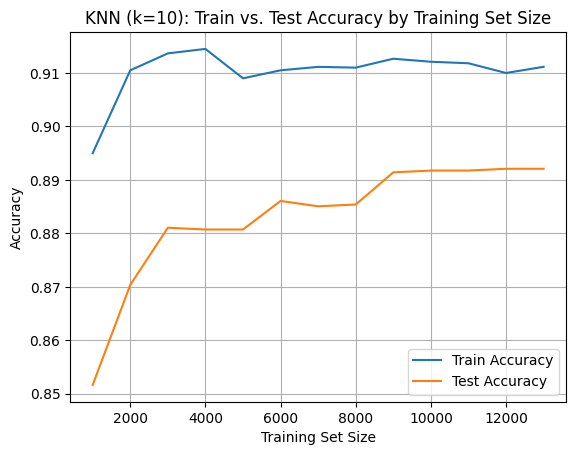

In [10]:
plt.figure()
plt.plot(sizes, train_accs, label='Train Accuracy')
plt.plot(sizes, test_accs,  label='Test Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('KNN (k=10): Train vs. Test Accuracy by Training Set Size')
plt.legend()
plt.grid(True)
plt.show()

Analyze the results.  If we want to improve the model's test set accuracy, what should we do -- add more training data, or choose a different model?

More data would help however it is starting to plateau so it would not have much effect. However, switching to a different more powerful model would have bigger gains. These could could be fine tuning the mobile netv2 model or replacing the knn with a neural net model.